<h1> DS200A Computer Vision Assignment</h1>

<h2>  Part Four: Neural networks </h2>	


Build a neural network classifier using an architecture of your choosing. This application
of deep learning can be done in PyTorch, TensorFlow, or a framework of your choice. This is the
industry standard for image classification. Describe your network and assess its performance. To
receive extra credit, your neural network classifier must outperform your other methods.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import skimage
from skimage import data
from skimage import io
import os
import cv2
import torch

In [2]:
data_original = pd.read_hdf("training_data.h5", "data")
print(len(data_original))

1501


In [3]:
data = data_original.copy()

#### Set parameters

In [4]:
batch_size = 32
img_w, img_h = 32, 32
num_classes = 20
split_ratio = 0.9
lr=0.01
momentum=0.9
weight_decay=1e-4

In [5]:
# Dataset processing
def load_data(df, img_w, img_h):
    '''
    load the image from df[picture] series
    return: image list, label list
    '''
    print('Reading training images')
    img_list, label_list = [], []
    for index, data in df.iterrows():
        img = data['Pictures']
        label = data['Encoding']
        #resize each image to the standard img_w * img_h 
        img = cv2.resize(img, (img_w, img_h), cv2.INTER_LINEAR)
        img_list.append(img), label_list.append(label)
    img_list, label_list = np.array(img_list, dtype=np.uint8), np.array( label_list, dtype=np.int32 )
    img_list = img_list.astype('float32')
    label_list = label_list.astype('long')
    img_list = img_list / 255
    return img_list, label_list

data, label = load_data(data, img_w, img_h)
print(data.shape, label.shape)

# shuffle the data
idx = np.arange( data.shape[0] )
np.random.shuffle(idx)
data, label = data[idx], label[idx]

Reading training images
(1501, 32, 32, 3) (1501,)


In [6]:
split = np.int(data.shape[0]* split_ratio)
x_train, y_train = data[:split].transpose(0,3,1,2), label[:split].reshape(-1)
x_val, y_val =data[split:].transpose(0,3,1,2), label[split:].reshape(-1)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(1350, 3, 32, 32) (1350,)
(151, 3, 32, 32) (151,)


#### normalize the intensity values

In [7]:
from torchvision import transforms

channel1_mean, channel1_std = x_train[:,0,:,:].mean(), x_train[:,0,:,:].std()
channel2_mean, channel2_std = x_train[:,1,:,:].mean(), x_train[:,1,:,:].std()
channel3_mean, channel3_std = x_train[:,2,:,:].mean(), x_train[:,2,:,:].std()

normalize_data = transforms.Compose([
    transforms.Normalize((channel1_mean, channel2_mean, channel3_mean),
                          (channel1_std, channel2_std, channel3_std)),
])    
for i in range(len(x_val)):
    x_val[i] = normalize_data(torch.from_numpy(x_val[i]))
for i in range(len(x_train)):
    x_train[i] = normalize_data(torch.from_numpy(x_train[i]))

In [8]:
from torch.utils.data.dataset import Dataset

class ImageDataset(Dataset):
    def __init__(self, image, label):
        self.image = image
        self.label = label
        
    def __getitem__(self, index):
        # stuff
        return (self.image[index], self.label[index])

    def __len__(self):
        return len(self.label)

In [9]:
train_dataset = ImageDataset(x_train, y_train)
val_dataset = ImageDataset(x_val, y_val)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

#### define the neural network architecture

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class QAlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(QAlexNet, self).__init__()
        self.conv1 = nn.Conv2d(
            3, 64, kernel_size=5, stride=1, padding=2)  # 32x32x3 -> 32x32x64
        # self.pool1=nn.MaxPool2d(kernel_size=3, stride=2, padding =1 )# 32x32x64
        # -> 16x16x64
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(
            64, 64, kernel_size=5, stride=1, padding=2)  # 16x16x64 -> 16x16x64
        # self.pool2=nn.MaxPool2d(kernel_size=3, stride=2, padding = 1)# 16x16x64
        # -> 8x8x64
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 8 * 8, 384) # self.fc1 = nn.Linear(64 * 8 * 8, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, num_classes)

    def squeeze_layers(self, sl=None):
        for k in self._modules.keys():
            if k in sl:
                for param in self._modules[k].parameters():
                    param.requires_grad = False
                    print(param.requires_grad)

    def back(self):
        for k in self._modules.keys():
            for param in self._modules[k].parameters():
                param.requires_grad = True

    def forward(self, x):
        x = F.max_pool2d(self.bn1(F.relu(self.conv1(x))), 3, 2, 1)
        x = F.max_pool2d(self.bn2(F.relu(self.conv2(x))), 3, 2, 1)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### helper functions

In [11]:
def one_hot(x, K):
    return np.array(x[:, None] == np.arange(K)[None, :], dtype=int)

def learning_rate_with_decay(
        lr,
        batch_size,
        batch_denom,
        batches_per_epoch,
        boundary_epochs,
        decay_rates):
    initial_learning_rate = lr*1. #* batch_size / batch_denom

    boundaries = [int(batches_per_epoch * epoch) for epoch in boundary_epochs]
    vals = [initial_learning_rate * decay for decay in decay_rates]

    def learning_rate_fn(itr):
        lt = [itr < b for b in boundaries] + [True]
        i = np.argmax(lt)
        return vals[i]

    return learning_rate_fn

def inf_generator(iterable):
    """
    Allows training with DataLoaders in a single infinite loop:
        for i, (x, y) in enumerate(inf_generator(train_loader)):
    """
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()
            
def accuracy(model, dataset_loader):
    total_correct = 0
    for x, y in dataset_loader:
        y = one_hot(np.array(y.numpy()), num_classes)
        target_class = np.argmax(y, axis=1)
        predicted_class = np.argmax(model(x).cpu().detach().numpy(), axis=1)
        total_correct += np.sum(predicted_class == target_class)
    return total_correct / len(dataset_loader.dataset)

In [12]:
model = QAlexNet(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()

In [13]:
data_gen = inf_generator(train_loader)
batches_per_epoch = len(train_loader)

lr_fn = learning_rate_with_decay(
    lr,
    batch_size,
    batch_denom=128,
    batches_per_epoch=batches_per_epoch,
    boundary_epochs=[30,60],
    decay_rates=[1, 0.1, 0.01]
)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr,
    momentum=momentum,
    weight_decay=weight_decay)

In [14]:
epoch = 0
iterations = 0
epoches, train_losses, val_accuracies = [], [], []
train_loss = 0.0

print(f'Numer of batches per epoch: {batches_per_epoch}')
while iterations < (100 * batches_per_epoch):

    iterations += 1

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr_fn(iterations)

    optimizer.zero_grad()
    x, y = data_gen.__next__()
    logits = model(x)
    loss = criterion(logits, y)
    train_loss += loss

    loss.backward()
    optimizer.step()

    if iterations % batches_per_epoch == 0:
        train_loss /= batches_per_epoch
        epoch += 1

        with torch.no_grad():
            val_acc = accuracy(model, val_loader)#, args)
            train_acc = accuracy(model, train_loader)#, args)
            print(
                "Epoch {:04d} | Val Acc {:.4f} | Train Acc {:.4f} | Training Loss {:.4f}".format(
                    iterations // batches_per_epoch,
                    val_acc, train_acc,
                    train_loss))
        epoches.append(epoch)
        train_losses.append(train_loss.data.item())
        val_accuracies.append(val_acc)
        train_loss = 0.


Numer of batches per epoch: 43
Epoch 0001 | Val Acc 0.2185 | Train Acc 0.3511 | Training Loss 2.6135
Epoch 0002 | Val Acc 0.3245 | Train Acc 0.4311 | Training Loss 2.1709
Epoch 0003 | Val Acc 0.3775 | Train Acc 0.5163 | Training Loss 1.8611
Epoch 0004 | Val Acc 0.4040 | Train Acc 0.5830 | Training Loss 1.5896
Epoch 0005 | Val Acc 0.3974 | Train Acc 0.6733 | Training Loss 1.3499
Epoch 0006 | Val Acc 0.4172 | Train Acc 0.7593 | Training Loss 1.0610
Epoch 0007 | Val Acc 0.4040 | Train Acc 0.9044 | Training Loss 0.7963
Epoch 0008 | Val Acc 0.3709 | Train Acc 0.8837 | Training Loss 0.4026
Epoch 0009 | Val Acc 0.4040 | Train Acc 0.9407 | Training Loss 0.3241
Epoch 0010 | Val Acc 0.4172 | Train Acc 0.9378 | Training Loss 0.5625
Epoch 0011 | Val Acc 0.4040 | Train Acc 0.9548 | Training Loss 0.2866
Epoch 0012 | Val Acc 0.3775 | Train Acc 0.9733 | Training Loss 0.1861
Epoch 0013 | Val Acc 0.4106 | Train Acc 0.9904 | Training Loss 0.1140
Epoch 0014 | Val Acc 0.4172 | Train Acc 0.9948 | Training L

In [16]:
results = pd.DataFrame({
    "epoches": epoches,
    "train_losses": train_losses,
    "val_accuracies": val_accuracies})
results.head()

,epoches,train_losses,val_accuracies
0,1,2.613469,0.218543
1,2,2.170919,0.324503
2,3,1.861059,0.377483
3,4,1.589582,0.403974
4,5,1.349873,0.397351


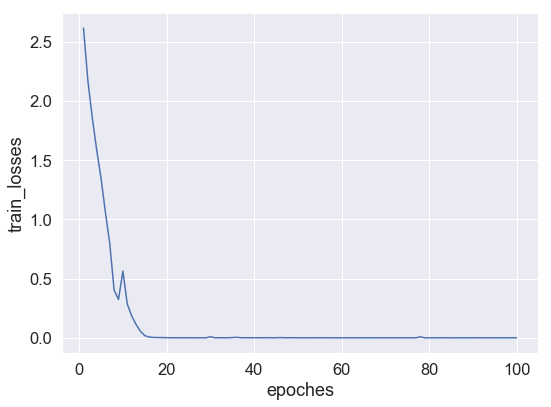

In [17]:
import seaborn as sns
import os
sns.set(font_scale=1.5)
try:
    os.stat("NB4_graph")
except:
    os.mkdir("NB4_graph")

plt.figure(figsize=(8, 6))
sns.lineplot(x="epoches", y="train_losses", data=results)
plt.tight_layout()
plt.savefig("NB4_graph/"+'trainloss'+".pdf")

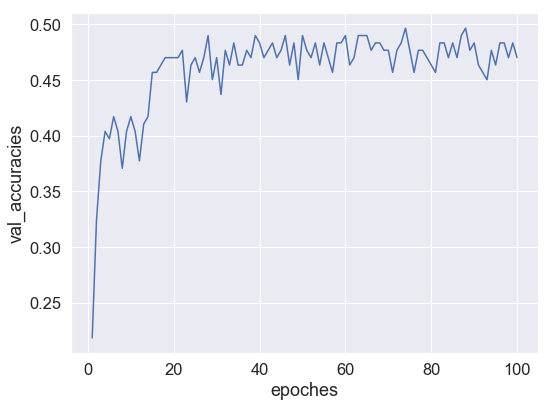

In [18]:
plt.figure(figsize=(8, 6))
sns.lineplot(x="epoches", y="val_accuracies", data=results)
plt.tight_layout()
plt.savefig("NB4_graph/"+'valaccuracy'+".pdf")